## Prediction of Significant Wave Height in Korea Strait using Machine Learning

## Import

In [ ]:
## pip install 'h5py==2.10.0' --force-reinstall

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'
# CPU :'os.environ["CUDA_VISIBLE_DEVICES"]='-1' , GPU :'os.environ["CUDA_VISIBLE_DEVICES"]='0'
import pandas as pd
from pandas import Timestamp
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(777)
tf.random.set_seed(777)

In [2]:
print(tf.__version__)
tf.test.gpu_device_name()

2.0.0


'/device:GPU:0'

## Load data

In [3]:
data = pd.read_csv('data/data_KS.csv')
data.dtypes

Date_Time        object
Cur_Vel         float64
Cur_Dir_deg       int64
Water_Temp      float64
Salty           float64
Sig_Wave_H      float64
Sig_Wave_P      float64
Max_Wave_H      float64
Max_Wave_P      float64
Wave_Dir_deg      int64
Wind_Vel        float64
Wind_Dir_deg      int64
Air_Temp        float64
Air_Pressure    float64
dtype: object

## Check exist of NaN data & Type conversion (float)

In [4]:
data.shape == data.dropna().shape # True: NaN data is not exist
data.iloc[:,1:13] = data.iloc[:,1:13].astype('float64')
data.Date_Time = data.Date_Time.astype('datetime64[ns]')

## Direction data conversion

In [5]:
Cur_Dir_cos = np.cos(data.Cur_Dir_deg*np.pi/180)
Cur_Dir_cos = Cur_Dir_cos.rename("Cur_Dir_cos")
Cur_Dir_sin = np.sin(data.Cur_Dir_deg*np.pi/180)
Cur_Dir_sin = Cur_Dir_sin.rename("Cur_Dir_sin")
Wind_Dir_cos = np.cos(data.Wind_Dir_deg*np.pi/180)
Wind_Dir_cos = Wind_Dir_cos.rename("Wind_Dir_cos")
Wind_Dir_sin = np.sin(data.Wind_Dir_deg*np.pi/180)
Wind_Dir_sin = Wind_Dir_sin.rename("Wind_Dir_sin")
data = pd.concat([data, Cur_Dir_cos, Cur_Dir_sin, Wind_Dir_cos, Wind_Dir_sin], axis=1)

In [6]:
pd.set_option('display.width', 140)
print(data)

                Date_Time  Cur_Vel  Cur_Dir_deg  Water_Temp  Salty  Sig_Wave_H  Sig_Wave_P  Max_Wave_H  Max_Wave_P  Wave_Dir_deg  \
0     2012-11-16 16:00:00    0.497         49.0        15.3  33.09        1.47         5.4        2.30         4.5         188.0   
1     2012-11-16 16:30:00    0.240         29.0        15.5  33.05        1.48         5.5        2.22         9.0          45.0   
2     2012-11-16 17:00:00    0.232         11.0        15.5  33.03        1.43         6.1        2.59         5.0          36.0   
3     2012-11-16 17:30:00    0.152         25.0        15.5  33.04        1.43         6.8        2.40        10.0          39.0   
4     2012-11-16 18:00:00    0.158         37.0        15.5  33.06        1.39         6.4        2.34         8.0          51.0   
...                   ...      ...          ...         ...    ...         ...         ...         ...         ...           ...   
98872 2020-12-31 21:30:00    0.166         78.0        14.7  34.09        1.

## Data slicing

In [7]:
data_train = data[data.Date_Time.between('2014-01-01 00:00:00', '2018-12-31 23:30:00')]
data_valid = data[data.Date_Time.between('2019-01-01 00:00:00', '2019-12-31 23:30:00')]
data_test = data[data.Date_Time.between('2020-01-01 00:00:00', '2020-12-31 23:30:00')]

## Neural Network

In [14]:
caseNum = 3
if caseNum==1:
    inputFeature = ['Wind_Vel', 'Wind_Dir_cos','Wind_Dir_sin'] # CaseNum = 1-1
elif caseNum == 2: 
    inputFeature = ['Cur_Dir_cos','Cur_Dir_sin', 'Wind_Vel', 'Wind_Dir_cos','Wind_Dir_sin'] # CaseNum = 2-2
elif caseNum == 3:
    inputFeature = ['Cur_Vel', 'Cur_Dir_cos','Cur_Dir_sin', 'Water_Temp', 'Salty', 'Wind_Vel', 'Wind_Dir_cos','Wind_Dir_sin', 'Air_Temp', 'Air_Pressure'] # CaseNum = 3-1

In [28]:
oX_data_train = data_train.loc[:, inputFeature].to_numpy()
oX_data_valid = data_valid.loc[:, inputFeature].to_numpy()
oX_data_test = data_test.loc[:, inputFeature].to_numpy()
print(np.array_str(oX_data_train, precision=2, suppress_small=True))
oX_data_train.shape

[[   0.15    0.93    0.37 ...    0.99   10.7  1011.2 ]
 [   0.09    0.47    0.88 ...    0.96   10.4  1011.4 ]
 [   0.07    0.98   -0.19 ...    0.95   10.3  1011.7 ]
 ...
 [   0.72    0.64    0.77 ...   -0.16   12.9  1020.8 ]
 [   0.63    0.73    0.68 ...    0.19   12.8  1020.4 ]
 [   0.57    0.79    0.62 ...    0.56   12.2  1020.  ]]


(72920, 10)

## Standardization

In [77]:
X_mean_train = oX_data_train.mean(axis=0)
std_train = oX_data_train.std(axis=0)
X_data_train = oX_data_train - X_mean_train
X_train = X_data_train / std_train
X_data_valid = oX_data_valid - X_mean_train
X_valid = X_data_valid / std_train
X_data_test = oX_data_test - X_mean_train
X_test = X_data_test / std_train
X_train[:,[1,2,6,7]]=oX_data_train[:,[1,2,6,7]]
X_valid[:,[1,2,6,7]]=oX_data_valid[:,[1,2,6,7]]
X_test[:,[1,2,6,7]]=oX_data_test[:,[1,2,6,7]]
print(np.array_str(X_train, precision=2, suppress_small=True))
X_train.shape

[[-0.58  0.93  0.37 ...  0.99 -0.18 -0.55]
 [-0.73  0.47  0.88 ...  0.96 -0.2  -0.53]
 [-0.77  0.98 -0.19 ...  0.95 -0.21 -0.49]
 ...
 [ 0.86  0.64  0.77 ... -0.16 -0.03  0.73]
 [ 0.63  0.73  0.68 ...  0.19 -0.04  0.68]
 [ 0.48  0.79  0.62 ...  0.56 -0.08  0.63]]


(72920, 10)

## Input Y data set-up

In [79]:
Y_train = data_train.Sig_Wave_H.to_numpy()
Y_valid = data_valid.Sig_Wave_H.to_numpy()
Y_test = data_test.Sig_Wave_H.to_numpy()

#### https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

In [80]:
len(inputFeature)

10

In [131]:
nodeNum = len(inputFeature) # Hidden layer node # 30
upStepNum = 8
upLayerNum = 8 # Hidden layer # 10
downStepNum = 6
downLayerNum = 12 # Hidden layer # 10
batchNum = 512 # Batch num
epochNum = 500 # EpochNum
dropNum = 0.001 # Drop out Num
regularNum = 0.00001
patienceNum = epochNum #PatienceNum = EpochNum
act_hid_fn = 'relu' # relu tanh, sigmoid
act_out_fn = 'sigmoid'
opti_fn = 'adam'
opt = keras.optimizers.Adam(learning_rate=0.000025)
loss_fn ='mae'  # 'mae', mse' 'logcosh'

case_name = 'FNN1_IN'+str(len(inputFeature))+'_NO'+str(nodeNum)+'_LA'+str(layerNum)+'_EP'+str(epochNum)+'_DP'+str(dropNum)+'_'+act_hid_fn  # case name for graph
MODEL_SAVE_FOLDER_PATH = './model/'+case_name+'/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
# Directory set-up for result data
model_path = MODEL_SAVE_FOLDER_PATH + 'ocean-' + '{epoch:04d}-{val_loss:.4f}.hdf5'
print(model_path)

# To save model during learning process
cb_checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=0, save_best_only=True)
# To check best model
cb_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patienceNum)
# To make model
model = keras.models.Sequential()
model.add(keras.layers.Dense(nodeNum, activation= act_hid_fn, input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dropout(rate=dropNum))
for i in range(upLayerNum):
    nodeNum += upStepNum
    print(nodeNum)
    model.add(keras.layers.Dense(nodeNum, kernel_regularizer=keras.regularizers.l2(regularNum), activation=act_hid_fn))
    model.add(keras.layers.Dropout(rate=dropNum))
for i in range(downLayerNum):
    nodeNum -= downStepNum
    print(nodeNum)
    model.add(keras.layers.Dense(nodeNum, kernel_regularizer=keras.regularizers.l2(regularNum), activation=act_hid_fn))
    model.add(keras.layers.Dropout(rate=dropNum))
model.add(keras.layers.Dense(1)) #, activation=act_out_fn

model.compile(optimizer = opt, loss = loss_fn, metrics=['mae','mse'])   # mae --> mse // opti_fn

model.layers
model.summary()

./model/FNN1_IN10_NO10_LA12_EP500_DP0.001_relu/ocean-{epoch:04d}-{val_loss:.4f}.hdf5
18
26
34
42
50
58
66
74
68
62
56
50
44
38
32
26
20
14
8
2
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_380 (Dense)            (None, 10)                110       
_________________________________________________________________
dropout_360 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_381 (Dense)            (None, 18)                198       
_________________________________________________________________
dropout_361 (Dropout)        (None, 18)                0         
_________________________________________________________________
dense_382 (Dense)            (None, 26)                494       
_________________________________________________________________
dropout_362 (Dropout)        (None, 26)   

## Learning process

In [132]:
history = model.fit(X_train, Y_train, epochs=epochNum, batch_size=batchNum, 
    validation_data = (X_valid, Y_valid), callbacks=[cb_checkpoint, cb_early_stopping])

Train on 72920 samples, validate on 10216 samples
Epoch 1/500
72704/72920 [============================>.] - ETA: 0s - loss: 1.0328 - mae: 1.0251 - mse: 1.4887
Epoch 00001: val_loss improved from inf to 1.04087, saving model to ./model/FNN1_IN10_NO10_LA12_EP500_DP0.001_relu/ocean-0001-1.0409.hdf5
72920/72920 [==============================] - 4s 53us/sample - loss: 1.0329 - mae: 1.0251 - mse: 1.4887 - val_loss: 1.0409 - val_mae: 1.0332 - val_mse: 1.7895
Epoch 2/500
72192/72920 [============================>.] - ETA: 0s - loss: 0.9362 - mae: 0.9286 - mse: 1.3062
Epoch 00002: val_loss improved from 1.04087 to 0.74859, saving model to ./model/FNN1_IN10_NO10_LA12_EP500_DP0.001_relu/ocean-0002-0.7486.hdf5
72920/72920 [==============================] - 2s 21us/sample - loss: 0.9343 - mae: 0.9267 - mse: 1.3034 - val_loss: 0.7486 - val_mae: 0.7410 - val_mse: 1.2324
Epoch 3/500
71680/72920 [============================>.] - ETA: 0s - loss: 0.5466 - mae: 0.5391 - mse: 0.5976
Epoch 00003: val_los

In [133]:
hist_df = pd.DataFrame(history.history)
hist_csv_file = MODEL_SAVE_FOLDER_PATH+'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Plot: Learning curve

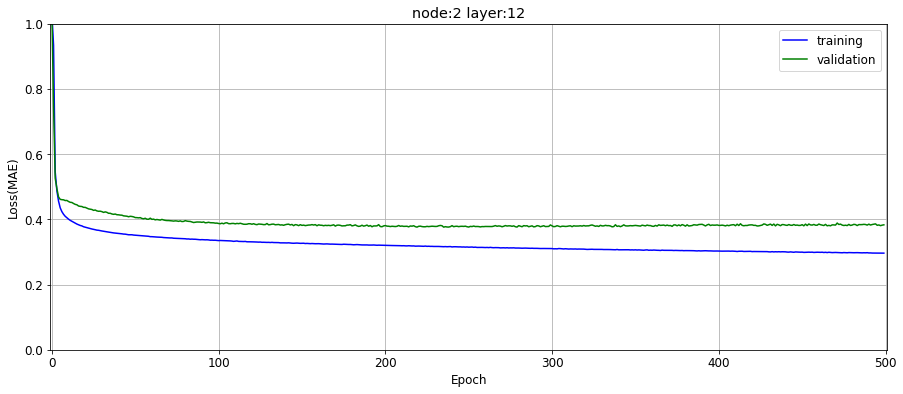

In [134]:
plt.plot(pd.DataFrame(history.history)[['loss']],'b', label='training')
plt.plot(pd.DataFrame(history.history)[['val_loss']],'g', label='validation')
# plt.figure(figsize=(5,5), dpi=10000, facecolor='w', edgecolor='k')
plt.xlabel("Epoch")
plt.ylabel("Loss(MAE)")  # "Loss(MAE)"  logcosh
plt.rcParams['figure.figsize'] = [15, 6]
font = {'weight' : 'normal', 'size' : 12}
plt.rc('font', **font)
plt.title('node:' + str(nodeNum)+' layer:'+str(layerNum))
plt.grid(True)
plt.legend()
plt.xlim(-1, epochNum+1)
plt.ylim(0, 1)
plt.savefig(MODEL_SAVE_FOLDER_PATH+'_lc_'+case_name+'.png', dpi=300)
plt.show()

In [135]:
predict_targets = model.predict(X_test) #X_test
test_targets = Y_test #Y_test
test_score= model.evaluate(X_test, Y_test)
test_mae_score = test_score[1]

13586/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Plot: Time-series (Final model)

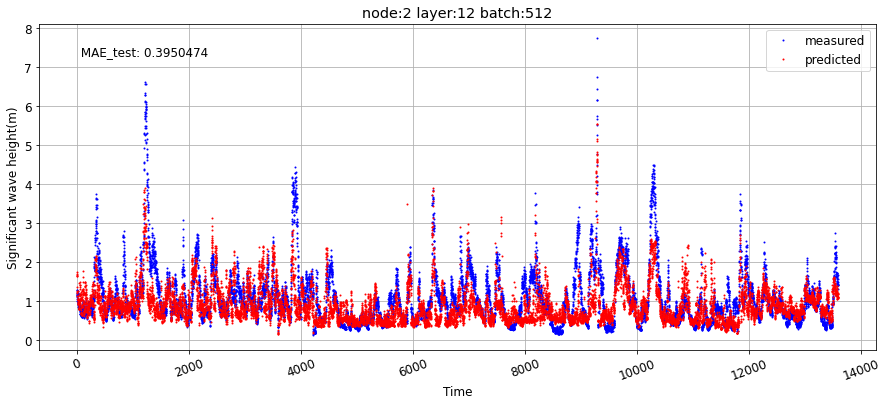

In [136]:
Test_Date_Time = pd.to_datetime(data_test.Date_Time)
plt.plot(test_targets, 'b.',label='measured', markersize=2)
plt.plot(predict_targets,'r.',label='predicted', markersize=2)

plt.title('node:' + str(nodeNum)+' layer:'+str(layerNum)+' batch:'+str(batchNum))
plt.ylabel('Significant wave height(m)')
plt.xlabel('Time')
plt.xticks(rotation=20)

plt.rcParams['figure.figsize'] = [15, 6]
plt.grid(True)
plt.legend()
plt.text(0, 7.3, ' MAE_test: '+str(test_mae_score))
# plt.text(0, 7.3, ' MSE_test: '+str(test_mse_score))
plt.savefig(MODEL_SAVE_FOLDER_PATH+'_ts_'+case_name+'.png', dpi=300)
plt.show()

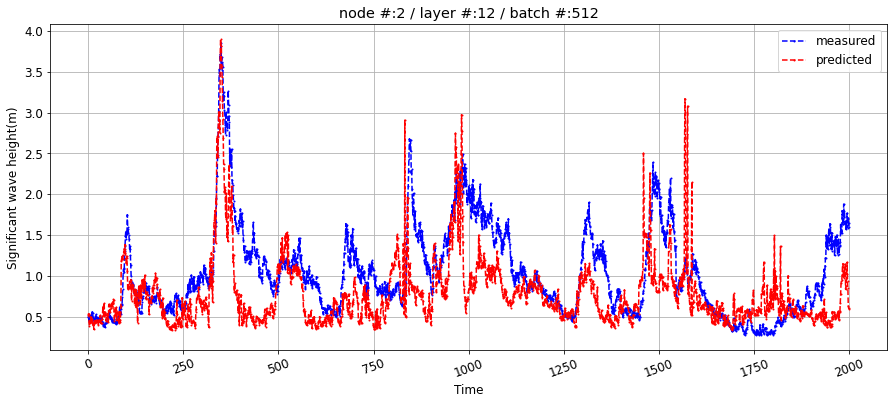

In [143]:
n1 = 6000
n2 = 2000
plt.plot(test_targets[n1:n1+n2], 'b.--',label='measured', markersize=2)
plt.plot(predict_targets[n1:n1+n2],'r.--',label='predicted', markersize=2)
plt.title('node #:' + str(nodeNum)+' / layer #:'+str(layerNum)+' / batch #:'+str(batchNum))
plt.ylabel('Significant wave height(m)')
plt.xlabel('Time')
plt.xticks(rotation=20)
plt.rcParams['figure.figsize'] = [15, 6]
plt.grid(True)
plt.legend()
plt.savefig(MODEL_SAVE_FOLDER_PATH+'_tsd_'+case_name+'.png', dpi=300)
plt.show()

## Load best model

In [104]:
model_list = os.listdir(MODEL_SAVE_FOLDER_PATH)
print(model_list)

['ocean-0071-0.3868.hdf5', 'ocean-0029-0.4191.hdf5', 'ocean-0009-0.5225.hdf5', 'ocean-0118-0.3766.hdf5', 'ocean-0050-0.3982.hdf5', 'ocean-0220-0.3720.hdf5', 'ocean-0061-0.3904.hdf5', 'ocean-0184-0.3736.hdf5', 'ocean-0309-0.3689.hdf5', 'ocean-0002-0.9640.hdf5', 'ocean-0076-0.3853.hdf5', 'ocean-0255-0.3703.hdf5', 'ocean-0104-0.3784.hdf5', 'ocean-0039-0.4064.hdf5', 'ocean-0053-0.3952.hdf5', 'ocean-0310-0.3688.hdf5', 'ocean-0044-0.4013.hdf5', 'ocean-0023-0.4331.hdf5', 'ocean-0016-0.4621.hdf5', 'ocean-0082-0.3835.hdf5', 'ocean-0073-0.3866.hdf5', 'ocean-0085-0.3823.hdf5', 'ocean-0004-0.6990.hdf5', 'ocean-0360-0.3682.hdf5', 'ocean-0038-0.4079.hdf5', 'ocean-0017-0.4573.hdf5', 'ocean-0337-0.3683.hdf5', 'ocean-0065-0.3892.hdf5', 'ocean-0100-0.3792.hdf5', 'ocean-0110-0.3781.hdf5', 'ocean-0055-0.3936.hdf5', 'ocean-0043-0.4033.hdf5', 'ocean-0077-0.3851.hdf5', 'ocean-0032-0.4152.hdf5', 'ocean-0227-0.3719.hdf5', 'ocean-0051-0.3972.hdf5', 'ocean-0042-0.4042.hdf5', 'ocean-0005-0.5861.hdf5', 'ocean-0081

In [105]:
model_list = list(filter(lambda k: 'ocean' in k, model_list))
maxNum=0
for ii in range(len(model_list)):
    if len(model_list[ii].split('-'))>1:
        if int(model_list[ii].split('-')[1])>= maxNum:
            maxNum= int(model_list[ii].split('-')[1])
            maxIdx = ii
model_list[maxIdx]
model_load_path = MODEL_SAVE_FOLDER_PATH+model_list[maxIdx]
print(model_list[maxIdx])
print(model_load_path)

ocean-0383-0.3678.hdf5
./model/FNN1_IN10_NO16_LA12_EP500_DP0.01_relu/ocean-0383-0.3678.hdf5


In [106]:
best_model = keras.models.load_model(model_load_path, )

In [116]:
# test_mse_score_best, test_mae_score_best = best_model.evaluate(X_test, Y_test)
# test_mae_score_best #test_mae_score_best test_mse_score_best
b = best_model.evaluate(X_test, Y_test);

13586/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [115]:
test_mae_score_best = b[1];

In [115]:
best_predict_targets = best_model.predict(X_test);

13586/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [108]:
best_predict_targets.shape

(13586, 1)

In [109]:
test_mae_score_best #test_mse_score_best

0.36768693

## Plot: Time-series (Best model)

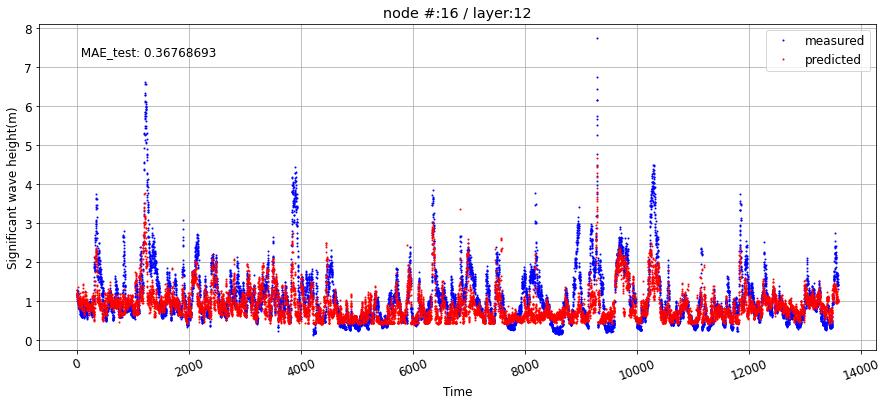

In [110]:
plt.plot(test_targets, 'b.',label='measured', markersize=2)
plt.plot(best_predict_targets,'r.',label='predicted', markersize=2)
plt.title('node #:' + str(nodeNum)+' / layer:'+str(layerNum))
plt.ylabel('Significant wave height(m)')
plt.xlabel('Time')
plt.xticks(rotation=20)
plt.rcParams['figure.figsize'] = [15, 6]
plt.grid(True)
plt.legend()
plt.text(0, 7.3, ' MAE_test: '+str(test_mae_score_best))
# plt.text(0, 7.3, ' MSE_test: '+str(test_mse_score_best))
plt.savefig(MODEL_SAVE_FOLDER_PATH+'tsb_'+case_name+'.png', dpi=300)
plt.show()

In [111]:
np.savetxt(MODEL_SAVE_FOLDER_PATH+case_name+'.txt',(best_predict_targets),header = 'Sig.wave height (m)')

In [112]:
MODEL_SAVE_FOLDER_PATH+case_name+'.txt'

'./model/FNN1_IN10_NO16_LA12_EP500_DP0.01_relu/FNN1_IN10_NO16_LA12_EP500_DP0.01_relu.txt'

## keras.sequence test

In [ ]:
def relu(X):
   return np.maximum(0,X)

In [ ]:
weights = model.get_weights()
#print(weights)

In [ ]:
print(np.array_str(weights[0], precision=2, suppress_small=True))

In [ ]:
print(np.array_str(weights[1], precision=2, suppress_small=True))

In [ ]:
n=5
x=X_test[0:n,:]
print(X_test.shape)
print(np.array_str(x, precision=2, suppress_small=True))

In [ ]:
yp = model.predict(x)
print(np.array_str(yp, precision=2, suppress_small=True))

In [ ]:
yt = Y_test[0:n]
print(np.array_str((yt.reshape(n,1)), precision=2, suppress_small=True))

In [ ]:
print(np.array_str((yt.reshape(n,1)-yp), precision=2, suppress_small=True))

In [ ]:
l0=np.matmul(x, weights[0])
print(np.array_str(l0, precision=2, suppress_small=True))

In [ ]:
l0=l0+weights[1]
print(np.array_str(l0, precision=2, suppress_small=True))

In [ ]:
l00=relu(l0)
print(np.array_str(l00, precision=2, suppress_small=True))

In [ ]:
l1=np.matmul(l00, weights[2])+weights[3]
print(np.array_str(l1, precision=2, suppress_small=True))